In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal/animals/dogs/dogs_00082.jpg
/kaggle/input/animal/animals/dogs/dogs_00041.jpg
/kaggle/input/animal/animals/dogs/dogs_00087.jpg
/kaggle/input/animal/animals/dogs/dogs_00010.jpg
/kaggle/input/animal/animals/dogs/dogs_00025.jpg
/kaggle/input/animal/animals/dogs/dogs_00097.jpg
/kaggle/input/animal/animals/dogs/dogs_00049.jpg
/kaggle/input/animal/animals/dogs/dogs_00067.jpg
/kaggle/input/animal/animals/dogs/dogs_00020.jpg
/kaggle/input/animal/animals/dogs/dogs_00016.jpg
/kaggle/input/animal/animals/dogs/dogs_00035.jpg
/kaggle/input/animal/animals/dogs/dogs_00028.jpg
/kaggle/input/animal/animals/dogs/dogs_00080.jpg
/kaggle/input/animal/animals/dogs/dogs_00070.jpg
/kaggle/input/animal/animals/dogs/dogs_00085.jpg
/kaggle/input/animal/animals/dogs/dogs_00081.jpg
/kaggle/input/animal/animals/dogs/dogs_00048.jpg
/kaggle/input/animal/animals/dogs/dogs_00099.jpg
/kaggle/input/animal/animals/dogs/dogs_00006.jpg
/kaggle/input/animal/animals/dogs/dogs_00084.jpg
/kaggle/input/animal

In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [5]:
def load_animal_dataset(dataset_path, image_size=(32, 32)):
    data = []
    labels = []
    label_map = {"cats": 0, "dogs": 1, "panda": 2}

    for label_name in label_map:
        folder_path = os.path.join(dataset_path, label_name)
        for file_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file_name)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Unable to read {image_path}")
                    continue
                image = cv2.resize(image, image_size)
                data.append(image.flatten())
                labels.append(label_map[label_name])
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return np.array(data), np.array(labels)

In [6]:
# Load and split
X, y = load_animal_dataset(dataset_path="/kaggle/input/animal/animals")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (240, 3072)
Train labels shape:  (240,)
Test data shape:  (60, 3072)
Test labels shape:  (60,)


In [8]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [12]:
import numpy as np

class KNearestNeighbor(object):
    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))

        for i in range(num_test):
            for j in range(num_train):
                dists[i, j] = np.sum(np.abs(X[i] - self.X_train[j]))
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test, dtype=int)

        for i in range(num_test):
            nearest_idxs = np.argsort(dists[i])[:k]
            closest_y = np.array(self.y_train[nearest_idxs]).flatten().astype(int)
            counts = np.bincount(closest_y)
            y_pred[i] = np.argmax(counts)

        return y_pred

    def predict(self, X, k=1):
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k=k)

In [14]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

# predict using loop-based distance calculation
y_test_pred = classifier.predict(X_test, k=5)

# evaluate
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]

print(f'accuracy: {accuracy:.2f}')

accuracy: 0.30


In [16]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20]

# split data into 5 folds
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []

    for fold in range(num_folds):
        # validation set for this fold
        X_val = X_train_folds[fold]
        y_val = y_train_folds[fold]

        # training set = all other folds
        X_train_fold = np.concatenate([X_train_folds[i] for i in range(num_folds) if i != fold])
        y_train_fold = np.concatenate([y_train_folds[i] for i in range(num_folds) if i != fold])

        # train and evaluate
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)
        dists = classifier.compute_distances(X_val)
        y_val_pred = classifier.predict_labels(dists, k=k)

        acc = np.mean(y_val_pred == y_val)
        k_to_accuracies[k].append(acc)

In [17]:
# Average accuracy for each k
for k in k_choices:
    accs = k_to_accuracies[k]
    accs_formatted = [f"{acc:.4f}" for acc in accs]
    avg_acc = np.mean(accs)
    print(f"k = {k}, accuracies = {accs_formatted}, mean accuracy = {avg_acc:.4f}")

# Find k with highest average accuracy
best_k = max(k_to_accuracies, key=lambda k: np.mean(k_to_accuracies[k]))
print(f'\nBest k based on cross-validation: {best_k}')

k = 1, accuracies = ['0.5208', '0.3958', '0.4167', '0.3750', '0.4583'], mean accuracy = 0.4333
k = 3, accuracies = ['0.4792', '0.3542', '0.3333', '0.3542', '0.4375'], mean accuracy = 0.3917
k = 5, accuracies = ['0.5000', '0.3125', '0.3542', '0.3333', '0.5000'], mean accuracy = 0.4000
k = 8, accuracies = ['0.5208', '0.3333', '0.3958', '0.2917', '0.4375'], mean accuracy = 0.3958
k = 10, accuracies = ['0.5417', '0.3125', '0.3958', '0.3125', '0.4167'], mean accuracy = 0.3958
k = 12, accuracies = ['0.4792', '0.3125', '0.3750', '0.3542', '0.5208'], mean accuracy = 0.4083
k = 15, accuracies = ['0.4583', '0.3333', '0.3958', '0.3333', '0.4375'], mean accuracy = 0.3917
k = 20, accuracies = ['0.4792', '0.3333', '0.3750', '0.2708', '0.5208'], mean accuracy = 0.3958

Best k based on cross-validation: 1


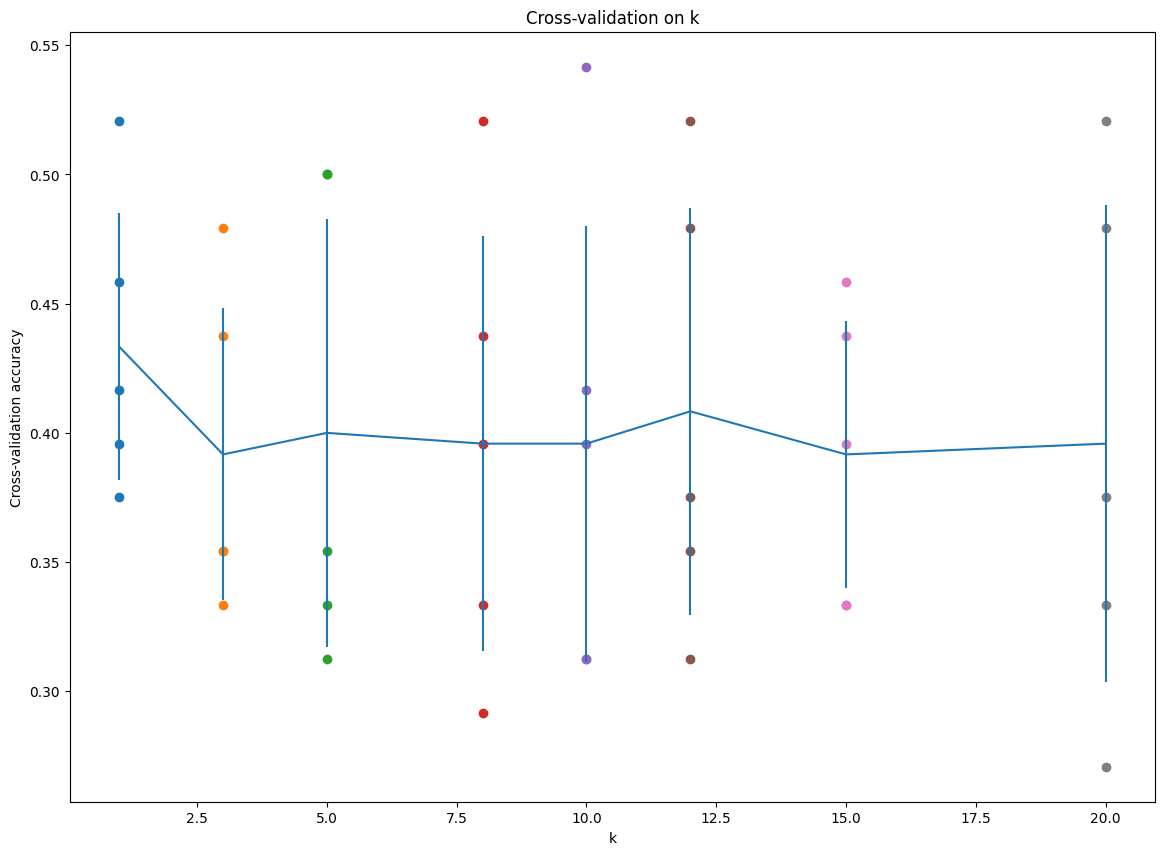

In [18]:
plt.figure(figsize=(14, 10))
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()